In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

In [2]:
data = pd.read_csv('../data/customer_data.csv', encoding='ISO-8859-1', parse_dates=['InvoiceDate'])

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Aggregate data at customer level
data['TotalSum'] = data['UnitPrice'] * data['Quantity'] # create col of total basket value

snapshot_date = data['InvoiceDate'].max() + timedelta(days=1) # date to cal days since last purchase

customer = (
    data.groupby(['CustomerID'])
    .agg(
        {
            'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # days since last purchase
            'InvoiceNo': 'count', # frequency of purchase
            'TotalSum': 'sum' # total value of purchase
        }
    )
)

# Rename columns for understandability
customer.rename(
    columns = {
        'InvoiceDate': 'recency',
        'InvoiceNo': 'frequency',
        'TotalSum': 'value'
    }, inplace=True
)

# Remove negative values
customer = customer[customer['value'] >= 0]


Text(0.5, 0.98, 'RFM Distributions')

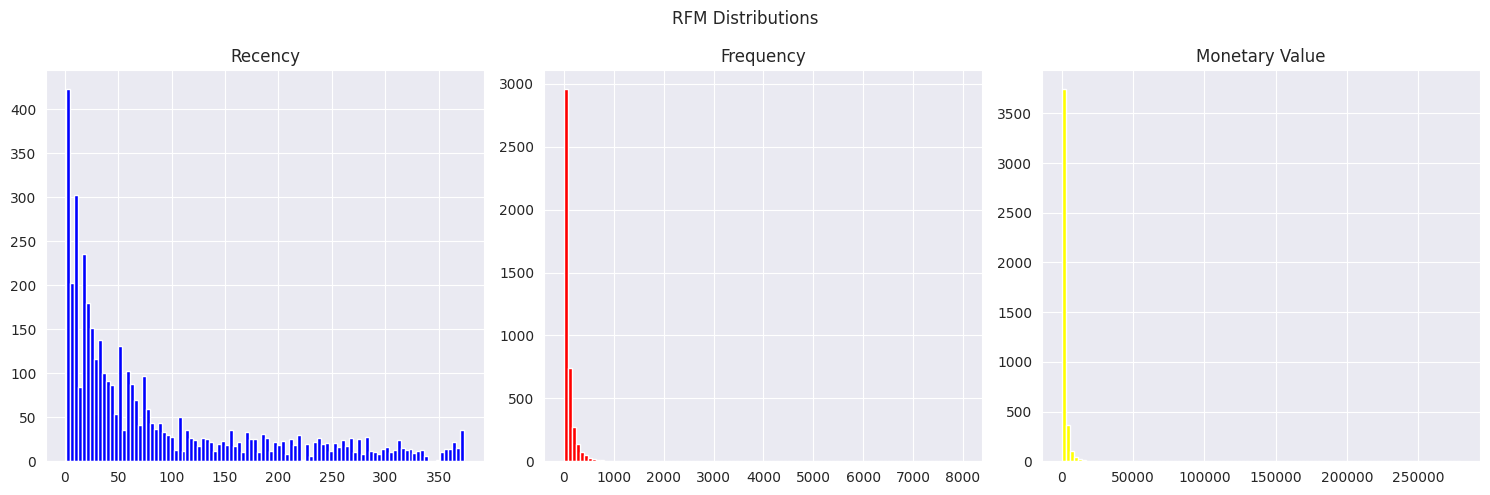

In [6]:
# Plot distributions of RFM
n_bins = 100

fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axs[0].hist(customer['recency'], bins=n_bins, color='blue')
axs[0].set_title('Recency')

axs[1].hist(customer['frequency'], bins=n_bins, color='red')
axs[1].set_title('Frequency')

axs[2].hist(customer['value'], bins=n_bins, color='yellow')
axs[2].set_title('Monetary Value')

fig.suptitle('RFM Distributions')

In [7]:
# Create Quartiles for R, F, M
r_labels = range(4, 0, -1) # more desirable to be recent
f_labels = range(1, 5)
m_labels = range(1, 5)

r_groups = pd.qcut(customer['recency'], q=4, labels=r_labels)
f_groups = pd.qcut(customer['frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(customer['value'], q=4, labels=m_labels)

customer = customer.assign(
    R = r_groups.values,
    F = f_groups.values,
    M = m_groups.values
)

In [8]:
customer.head()

,recency,frequency,value,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [9]:
# Summing the Score
customer['rfm_score'] = customer[['R', 'F', 'M']].sum(axis=1)

# Concat score segments
customer['rfm_segment'] = customer.apply(
    lambda x: str(int(x['R'])) + str(int(x['F'])) + str(int(x['M'])), axis=1
)

In [10]:
customer.head()

,recency,frequency,value,R,F,M,rfm_score,rfm_segment
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,3,111
12347.0,2,182,4310.00,4,4,4,12,444
12348.0,75,31,1797.24,2,2,4,8,224
12349.0,19,73,1757.55,3,3,4,10,334
12350.0,310,17,334.40,1,1,2,4,112


In [11]:
rfm_segment_aggregates = (
    pd.pivot_table(
        data=customer.reset_index(),
        index='rfm_segment',
        values=['CustomerID', 'rfm_score'],
        aggfunc={
            'CustomerID': pd.Series.nunique,
            'rfm_score': 'max'
        }
    )
    .rename(
        columns={
            'CustomerID': 'customer_count'
        }
    )
)

In [12]:
rfm_segment_aggregates.sort_values(by='rfm_score', ascending=False)

,customer_count,rfm_score
rfm_segment,,
444,468,12
443,86,11
344,206,11
434,77,11
442,13,10
...,...,...
113,20,5
112,117,4
211,183,4


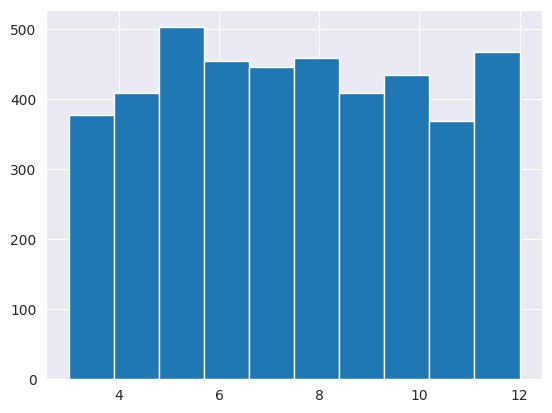

In [13]:
# plot distribution of rfm scores
plt.hist(customer['rfm_score'])
plt.show()


In [14]:
# Define RFM segments
def rfm_desc_segments(x):
    if x['rfm_score'] >= 9:
        return 'Tier 1 - Champions'
    elif 8 <= x['rfm_score'] < 9:
        return 'Tier 2 - VIPs'
    elif 7 <= x['rfm_score'] < 8:
        return 'Tier 3 - Regulars'
    elif 6 <= x['rfm_score'] < 7:
        return 'Tier 4 - Potential'
    elif 5 <= x['rfm_score'] < 6:
        return 'Tier 5 - Laggards'
    elif x['rfm_score'] < 5:
        return 'Tier 6 - Dormant'
    else:
        return 'Tier 7 - Reactivation'

customer['desc_segments'] = customer.apply(rfm_desc_segments, axis=1)

In [15]:
customer.head()

,recency,frequency,value,R,F,M,rfm_score,rfm_segment,desc_segments
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,3,111,Tier 6 - Dormant
12347.0,2,182,4310.00,4,4,4,12,444,Tier 1 - Champions
12348.0,75,31,1797.24,2,2,4,8,224,Tier 2 - VIPs
12349.0,19,73,1757.55,3,3,4,10,334,Tier 1 - Champions
12350.0,310,17,334.40,1,1,2,4,112,Tier 6 - Dormant


In [16]:
customer['value_log'] = np.log(customer['value'] + 1)
customer['freq_log'] = np.log(customer['frequency'] + 0.000000000001)
customer['recency_log'] = np.log(customer['recency'] + 0.000000000001)

<Axes: xlabel='freq_log', ylabel='value_log'>

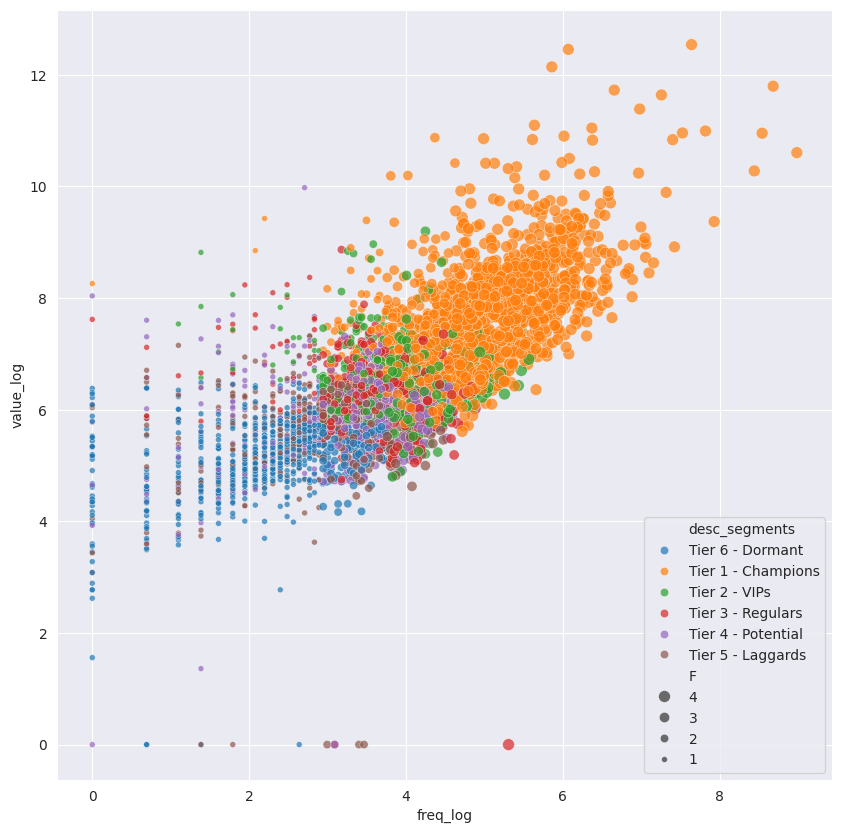

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    data=customer,
    x='freq_log',
    y='value_log',
    hue='desc_segments',
    # hue_order=['Tier 1 - Champions', 'Tier 2 - VIPs', 'Tier 3 - Regulars', 'Tier 4 - Potential', 'Tier 5 - Laggards', 'Tier 6 -Dormant', 'Tier 7 - Re-Activation'],
    size='F',
    size_order=[4,3,2,1],
    alpha=0.7
)

In [18]:
customer

,recency,frequency,value,R,F,M,rfm_score,rfm_segment,desc_segments,value_log,freq_log,recency_log
CustomerID,,,,,,,,,,,,
12346.0,326,2,0.00,1,1,1,3,111,Tier 6 - Dormant,0.000000,0.693147,5.786897
12347.0,2,182,4310.00,4,4,4,12,444,Tier 1 - Champions,8.368925,5.204007,0.693147
12348.0,75,31,1797.24,2,2,4,8,224,Tier 2 - VIPs,7.494564,3.433987,4.317488
12349.0,19,73,1757.55,3,3,4,10,334,Tier 1 - Champions,7.472245,4.290459,2.944439
12350.0,310,17,334.40,1,1,2,4,112,Tier 6 - Dormant,5.815324,2.833213,5.736572
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,111,Tier 6 - Dormant,5.201806,2.302585,5.627621
18281.0,181,7,80.82,1,1,1,3,111,Tier 6 - Dormant,4.404522,1.945910,5.198497
18282.0,8,13,176.60,4,1,1,6,411,Tier 4 - Potential,5.179534,2.564949,2.079442


In [19]:
segment_average = (
    customer[['desc_segments', 'recency', 'frequency', 'value']]
    .groupby('desc_segments')
    .mean()
)

customer_average = (
    customer[['recency', 'frequency', 'value']]
    .mean()
)

# Normalise data to calculate relative importance score
relative_importance = segment_average / customer_average - 1

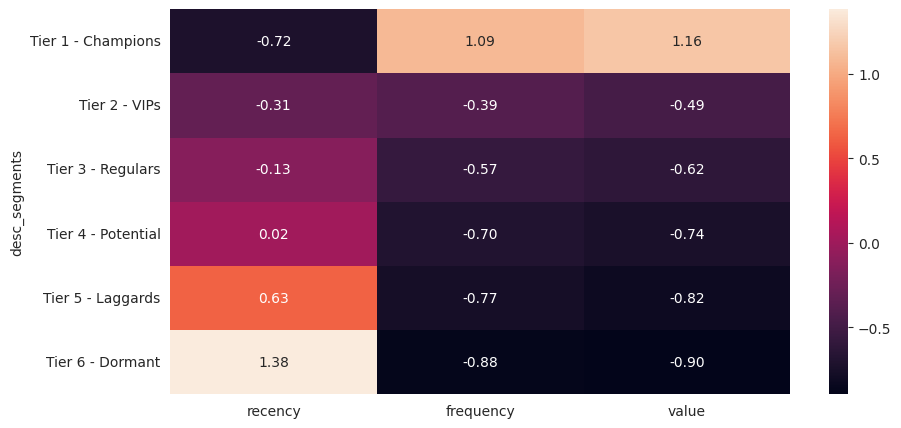

In [20]:
plt.figure(figsize=(10,5))

sns.heatmap(
    data=relative_importance,
    annot=True,
    fmt='.2f',
)

plt.show()